# Дообучение модели Gemma-2-2b

* Дообучим предобученную большую языковую модель `Gemma-2-2b` от компании `Google`.
* Модель `Gemma-2-2b` построена на улучшенной архитектуре GPT и имеет 2 млрд параметров. Ссылка на модель: <https://huggingface.co/google/gemma-2-2b>
* Для обучения используем библиотеку `transformers` от `Hugging Face` и `PyTorch` в качестве backend.
* Ссылка на данные: <https://github.com/yandex/geo-reviews-dataset-2023>

## Импорты

In [1]:
import os
import random
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset
from dotenv import load_dotenv
from huggingface_hub import login
from peft import LoraConfig, get_peft_model
from transformers import (AutoModelForCausalLM, AutoTokenizer,
                          DataCollatorForLanguageModeling,
                          EarlyStoppingCallback, Trainer, TrainingArguments)

## Настройки

In [2]:
def seed_all(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

# Для повторяемости результатов
SEED = 42
seed_all(SEED)
# Загрузка переменных из .env файла
load_dotenv()
# Чтение токена
token = os.getenv("HUGGING_FACE_ACCESS_TOKEN")
# Авторизация в Hugging Face
login(token)
# Отключим вывод предупреждений
warnings.filterwarnings('ignore')
# Устройство для тензорных вычислений и хранения модели в памяти.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Загрузка модели

* Используем `FP16` - половинную точность (half-precision) для весов модели. Это позволяет экономить память GPU без существенного снижения качества обучения модели.

In [3]:
model_name = "google/gemma-2-2b"
tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Половинная точность
    token=token,
)
model = model.to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Дообучение LoRA

`LoRA` (Low-Rank Adaptation of Large Language Models) - метод, который позволяет значительно сократить сложность и время дообучения больших языковых моделей  (LLM), за счёт заморозки матрицы весов. Вместо неё создаются и обучаются две малые матрицы весов низкой размерности. Итоговый результат получается сложением выходов новых матриц и замороженной матрицы. 

Метод основан на гипотезе, что для задачи дообучения LLM большинство параметров являются избыточными. Говорят, что при дообучении, LLM имеет низкий внутренний ранг (intrinsic rank).

Количество обучаемых параметров до применения LoRA.

In [4]:
def count_params(model):
    def pretty_number(num):
        return "{:,}".format(num).replace(",", " ")

    all_params = sum(p.numel() for p in model.parameters())
    grad_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Параметров:", pretty_number(all_params))
    print("Обучаемых параметров:", pretty_number(grad_params))

count_params(model)

Параметров: 2 614 341 888
Обучаемых параметров: 2 614 341 888


Применим LoRA к модели.

In [5]:
LORA_RANK = 6  # Ранг матриц LoRA

# Настройки LoRA
lora_config = LoraConfig(
    r=LORA_RANK,  # Ранг малых матриц, веса которых мы будем обучать
    lora_alpha=LORA_RANK,  # (alpha / r) - множитель для выходов малых обучаемых матриц
    lora_dropout=0.1,  # Dropout регуляризация для малых обучаемых матриц
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)

Примечание:

* В данном ноутбуке используем небольшое значение ранга матриц LoRA, т.к. есть ограничения в размере GPU памяти.
* При обучении финальной версии модели можно немного увеличить значение.

Количество обучаемых параметров после применения LoRA.

In [6]:
count_params(model)

Параметров: 2 615 539 968
Обучаемых параметров: 1 198 080


Видим, что общее количество весов модели выросло, как раз на количество обучаемых весов.

Примечание:

* Хотя мы обучаем всего около 1,2 млн параметров с помощью LoRA, скорость обучения будет примерно такой же, как если бы мы обучали модель с 200 млн параметров без LoRA. Это происходит потому, что на этапе прямого хода всё равно требуется использовать все 2,6 млрд параметров базовой модели для вычисления выходов, и только на этапе обратного распространения ошибки начинает работать оптимизация LoRA.

## Очистка данных

Очистим данные и создадим датасет.

In [7]:
df = pd.read_csv("../data/prepared/data.csv")
df["name_ru"] = df["name_ru"].fillna("")
df["text"] = df["text"].str.replace("\\n", " ")
df = df.drop_duplicates(ignore_index=True)

dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['address', 'name_ru', 'rating', 'rubrics', 'text'],
    num_rows: 499799
})

## Формируем входной текст

* При формировании входного текста, добавим в конец токен `<eos>` (End of sequence). Это поможет модели на этапе инференса «понять», когда нужно остановиться и не испортить сгенерированный отзыв, продолжая текст.
* Токенизируем все входные тексты и сохраним их длины в датасет для дальнейшего анализа.

In [8]:
def create_inputs(examples):
    # Формируем входной текст
    inputs = [
        f"Аddress: {address}\nName: {name}\nRating: {rating}\nKeywords: {rubrics}\nReview: {text}{tokenizer.eos_token}"
        for address, name, rating, rubrics, text in zip(
            examples["address"],
            examples["name_ru"],
            examples["rating"],
            examples["rubrics"],
            examples["text"],
        )
    ]
    # Длины токенизированных текстов
    lengths = [len(tokenizer.tokenize(input)) for input in inputs]
    return {"inputs": inputs, "lengths": lengths}


dataset = dataset.map(create_inputs, batched=True, remove_columns=dataset.column_names)
dataset

Map:   0%|          | 0/499799 [00:00<?, ? examples/s]

Dataset({
    features: ['inputs', 'lengths'],
    num_rows: 499799
})

## Анализ длин токенизированных текстов

Проведём анализ количества токенов в векторизованных текстах. Эта информация нужна нам для выбора оптимальной длины, к которой мы будем приводить все тексты в батчах данных.

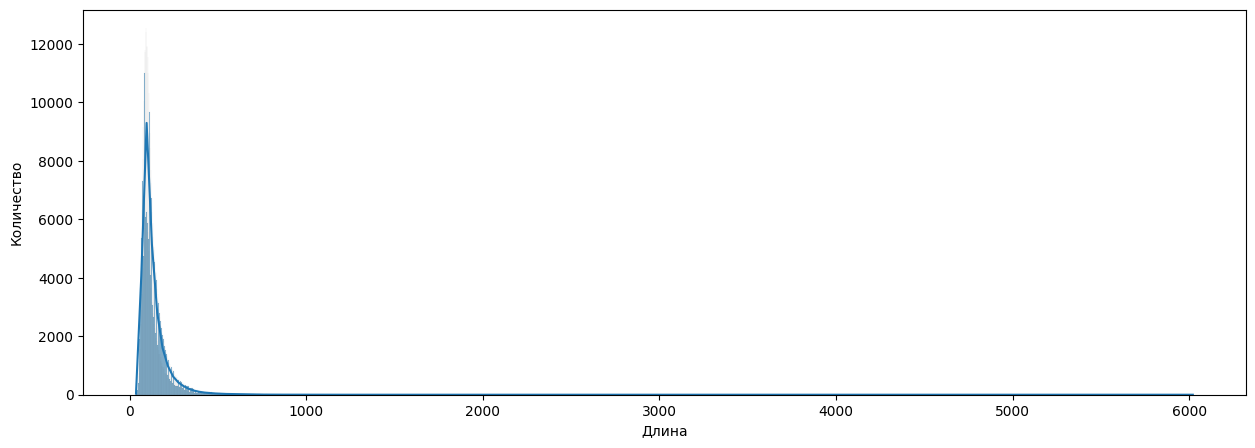

In [9]:
plt.figure(figsize=(15, 5))
sns.histplot(x=dataset["lengths"], kde=True)
plt.xlabel("Длина")
plt.ylabel("Количество")
plt.show()

In [10]:
np.quantile(dataset["lengths"], 0.95)

np.float64(274.0)

Выводы:

* 95% всех токенизированных текстов имеют длину 274 и меньше.
* Для обучения финальной версии модели можно будет взять длину 256 токенов.
* В данном ноутбуке, мы ограничимся длиной 128 токенов, т.к. есть ограниечения в размере GPU памяти и вычислительной мощности.

## Векторизация данных

In [11]:
MAX_LENGTH = 128


def tokenize_text(examples):
    # Векторизуем входной текст и приводим его к выбранной длине
    return tokenizer(
        examples["inputs"], max_length=MAX_LENGTH, padding="max_length", truncation=True
    )


tokenized_dataset = dataset.map(tokenize_text, batched=True, remove_columns=dataset.column_names)
tokenized_dataset

Map:   0%|          | 0/499799 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 499799
})

## Разделение данных

Возьмём только подвыборку из первых 10000 строк. Это уменьшит скорость обучения в 50 раз и позволит проверить гипотезы, подобрать гиперпараметры, проверить генерацию ответов моделью. Обучение же модели на всех данных может занять сутки и более на GPU уровня T4.

In [12]:
dataset_slice = tokenized_dataset.take(10000)
dataset_slice

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 10000
})

Разделение на тренировочную и оценочную подвыборки.

In [13]:
dataset_split = dataset_slice.train_test_split(test_size=0.1, shuffle=True, seed=SEED)
dataset_split

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

## Логирование MLFlow

* В проекте мы будем использовать инструмент `MLFlow` для логирования гиперпараметров, метрик и артефактов обучения.
* Библиотека `transformers` и платформа `MLFlow` имеют интеграцию, которую легко подключить.

In [14]:
MLFLOW_EXPERIMENT = "Gemma-2-2b-LoRA-Finetuning"

# Инициализация MLflow
mlflow.set_tracking_uri("../mlruns")  # Директория для логов в корне проекта
mlflow.set_experiment(MLFLOW_EXPERIMENT)  # Название эксперимента MLFlow

<Experiment: artifact_location='file:c:/Users/nymle/dev/repos/Project-3/notebooks/../mlruns/504564538381172679', creation_time=1734046167078, experiment_id='504564538381172679', last_update_time=1734046167078, lifecycle_stage='active', name='Gemma-2-2b-LoRA-Finetuning', tags={}>

## Гиперпараметры обучения

In [15]:
BATCH_SIZE = 4
GRAD_ACCUM = 1
N_EPOCHS = 5
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 0.01

n_steps = int(round(N_EPOCHS * len(dataset_split["train"]) / BATCH_SIZE / GRAD_ACCUM, 0))
print("Всего шагов обучения:", n_steps)

Всего шагов обучения: 11250


In [16]:
HUB_MODEL_ID = "nymless/gemma-2-2b-lora-finetuned"

training_args = TrainingArguments(
    # Включаем логирование в MLFlow
    report_to="mlflow",
    logging_steps=500,  # Через сколько шагов логировать
    # Генерация имени MLFlow Run с текущим временем и датой
    run_name=f"{MLFLOW_EXPERIMENT}-{datetime.now().strftime('%d.%m.%Y, %H:%M:%S')}",
    # Директория сохранения модели
    output_dir="../models/gemma-2-2b-lora-finetuned",
    # Параметры оценки и сохранения модели
    overwrite_output_dir=True,  # Перезапись директории при каждом запуске обучения
    save_strategy="epoch",  # Сохраняем модель в конце каждой эпохи
    load_best_model_at_end=True,  # Сохраняем лучшую по метрике модель в конце обучения
    metric_for_best_model="loss",  # Метрика для оценки модели
    save_total_limit=1,  # Сохранить только одну модель
    eval_strategy="epoch",  # Оценивать модель в конце каждой эпохи
    # Гиперпараметры
    learning_rate=LEARNING_RATE,  # Скорость обучения
    lr_scheduler_type="cosine",  # Cнижение по косинусоиде
    per_device_train_batch_size=BATCH_SIZE,  # Размер батча данных на этапе обучения
    per_device_eval_batch_size=BATCH_SIZE,  # Размер батча данных на этапе оценивания
    gradient_accumulation_steps=GRAD_ACCUM,  # Накапливать градиенты N шагов и подстроить веса
    num_train_epochs=N_EPOCHS,  # Количество эпох
    weight_decay=WEIGHT_DECAY,  # Коэффициент регуляризации
    fp16=True,  # Использовать формат чисел FP16 (Floating point 16-bit)
    # Работа с Hugging Face Hub (Отключено)
    push_to_hub=False,  # Сохранение модели в Hub со стандартным commit_message
    hub_model_id=HUB_MODEL_ID,  # Название модели в Hub
    hub_strategy="end",  # Загружать модель в Hub в конце обучения
    hub_token=token,  # Токен Hugging Face
)

Примечание:

* Мы оключили автоматическое сохранение модели в `Hugging Face Hub`. Сохраним модель вручную в конце ноутбука.

In [17]:
# Объект, который извлекает данные батчами для обучения
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Отключаем режим маскирования текста MLM (Masked language modeling)
)

Настроим раннюю остановку обучения если не будет улучшения метрики `eval_loss` хотя бы на `0,01` в течении `2` эпох.

In [18]:
# Объект, который управляет ранней остановкой обучения
early_topping_callback = EarlyStoppingCallback(
    early_stopping_patience=2, early_stopping_threshold=0.01
)

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_split["train"],
    eval_dataset=dataset_split["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    callbacks=[early_topping_callback]
)

## Обучение модели

In [20]:
trainer.train(
    resume_from_checkpoint=False, # Продолжить обучение с выбранного (или последнего) чекпоинта
)

  0%|          | 0/11250 [00:00<?, ?it/s]

{'loss': 2.0349, 'grad_norm': 0.7744771838188171, 'learning_rate': 0.0004975767236477413, 'epoch': 0.22}
{'loss': 1.9722, 'grad_norm': 0.8409476280212402, 'learning_rate': 0.0004903346577317858, 'epoch': 0.44}
{'loss': 1.9466, 'grad_norm': 0.7943012714385986, 'learning_rate': 0.0004784147510797024, 'epoch': 0.67}
{'loss': 1.9114, 'grad_norm': 0.7924661040306091, 'learning_rate': 0.000462049011115781, 'epoch': 0.89}


The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.9194800853729248, 'eval_runtime': 34.2026, 'eval_samples_per_second': 29.238, 'eval_steps_per_second': 7.309, 'epoch': 1.0}
{'loss': 1.8532, 'grad_norm': 0.8687607049942017, 'learning_rate': 0.00044160083098765813, 'epoch': 1.11}
{'loss': 1.839, 'grad_norm': 0.7698619365692139, 'learning_rate': 0.0004173863880864194, 'epoch': 1.33}
{'loss': 1.8373, 'grad_norm': 1.0663352012634277, 'learning_rate': 0.00038991395954027285, 'epoch': 1.56}
{'loss': 1.8311, 'grad_norm': 0.8138015270233154, 'learning_rate': 0.00035971826492144505, 'epoch': 1.78}
{'loss': 1.8064, 'grad_norm': 0.9945358633995056, 'learning_rate': 0.00032745341027141716, 'epoch': 2.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.877261757850647, 'eval_runtime': 34.0561, 'eval_samples_per_second': 29.363, 'eval_steps_per_second': 7.341, 'epoch': 2.0}
{'loss': 1.7468, 'grad_norm': 1.0055190324783325, 'learning_rate': 0.0002936182868119549, 'epoch': 2.22}
{'loss': 1.7295, 'grad_norm': 0.9167793989181519, 'learning_rate': 0.0002589341830147636, 'epoch': 2.44}
{'loss': 1.7292, 'grad_norm': 1.0301669836044312, 'learning_rate': 0.00022407618550767267, 'epoch': 2.67}
{'loss': 1.724, 'grad_norm': 1.0922505855560303, 'learning_rate': 0.000189722765561773, 'epoch': 2.89}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.8603359460830688, 'eval_runtime': 33.9913, 'eval_samples_per_second': 29.419, 'eval_steps_per_second': 7.355, 'epoch': 3.0}
{'loss': 1.6775, 'grad_norm': 1.3072201013565063, 'learning_rate': 0.00015667209105087133, 'epoch': 3.11}
{'loss': 1.6553, 'grad_norm': 1.4674419164657593, 'learning_rate': 0.00012530242164276233, 'epoch': 3.33}
{'loss': 1.6615, 'grad_norm': 1.2614058256149292, 'learning_rate': 9.635984875598389e-05, 'epoch': 3.56}
{'loss': 1.655, 'grad_norm': 1.7667028903961182, 'learning_rate': 7.040770665008852e-05, 'epoch': 3.78}
{'loss': 1.639, 'grad_norm': 1.4429086446762085, 'learning_rate': 4.7951124251043226e-05, 'epoch': 4.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.8611871004104614, 'eval_runtime': 34.2318, 'eval_samples_per_second': 29.213, 'eval_steps_per_second': 7.303, 'epoch': 4.0}
{'loss': 1.6119, 'grad_norm': 1.5476133823394775, 'learning_rate': 2.9460063324868917e-05, 'epoch': 4.22}
{'loss': 1.6177, 'grad_norm': 1.236956238746643, 'learning_rate': 1.522043955527963e-05, 'epoch': 4.44}
{'loss': 1.5993, 'grad_norm': 1.0764669179916382, 'learning_rate': 5.550532871955061e-06, 'epoch': 4.67}
{'loss': 1.5924, 'grad_norm': 1.1854642629623413, 'learning_rate': 6.385570091303194e-07, 'epoch': 4.89}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.869433879852295, 'eval_runtime': 34.114, 'eval_samples_per_second': 29.314, 'eval_steps_per_second': 7.328, 'epoch': 5.0}
{'train_runtime': 3560.1967, 'train_samples_per_second': 12.64, 'train_steps_per_second': 3.16, 'train_loss': 1.7544795030381946, 'epoch': 5.0}


TrainOutput(global_step=11250, training_loss=1.7544795030381946, metrics={'train_runtime': 3560.1967, 'train_samples_per_second': 12.64, 'train_steps_per_second': 3.16, 'total_flos': 7.000874385408e+16, 'train_loss': 1.7544795030381946, 'epoch': 5.0})

## Подбор гиперпараметров

* К сожалению, в подборе гиперпараметров мы ограничены только количеством эпох (`n_epochs`), скоростью обучения (`learning_rate`) и настройками планировщика скорости обучения (`lr_sheduler`).
* При увеличении размера батча (`batch_size`), длины токенизированного текста (`max_length`), или размера LoRA матриц (`lora_rank`), начинаются проблемы с нехваткой GPU памяти.
* Все пуски обучения производились со сбросом параметров модели к начальным значениям.

**Таблица параметров и метрик**

| № пуска | n_epochs | learning_rate | lr_sheduler | power | loss  | eval_loss | Лучшая эпоха | Ранняя остановка |
|---------|----------|---------------|-------------|-------|-------|-----------|--------------|------------------|
| 1       | 6        | 0.00002       | linear      | -     | 1.931 | 1.975     | 5            | 5                |
| 2       | 6        | 0.0005        | linear      | -     | 1.689 | 1.863     | 3            | 5                |
| 3       | 6        | 0.0005        | polynomial  | 0.4   | 1.697 | 1.870     | 3            | 5                |
| 4       | 5        | 0.0005        | cosine      | -     | 1.677 | 1.860     | 3            | -                |

**Обучение № 1**

* Модель не успела дообучиться из-за низкой начальной скорости обучения и её дальнейшего линейного снижения.
* Метрика `eval_loss` улучшалась слишком медленно, что привело к ранней остановке.


**Обучение № 2**

* Увеличили скоросто обучения `learning_rate = 0.0005`.
* На 3 эпохе была достигнута метрика качества `eval_loss = 1.863`. Модель обучилась лучше.

**Обучение № 3**

* Планировщик обучения заменили на полиномиальный `polynomial` со степенью полинома `power = 0.4`. Это позволило замедлить снижение скорости в начале обучения и затем, ускорить в конце.
* На 3 эпохе была достигнута метрика качества `eval_loss = 1.870`. Улучшение метрики достигнуто не было.

**Обучение № 4**

* Установили количество эпох `n_epochs = 5`.
* Планировщик обучения заменили на косинусный `cosine`. Это позволило получить медленное снижение в начале обучения, затем в середине плавно ускорить и в конце снова плавно замедлить.
* На 3 эпохе была достигнута метрика качества `eval_loss = 1.860`. Это лучший результат.

## Интерфейс MLFlow UI

Ниже показаны скриншоты интерфейса `MLFlow` по визуализиции логирования обучения. На них можно увидеть результаты экспериментов обучения модели с разными гиперпараметрами, их метрики и сравнительные графики. Все логи сохраняются в корне проекта в директории mlruns.

![alt text](<../resources/mlflow/Screenshot 2024-12-14 162736.png>)

![alt text](<../resources/mlflow/Screenshot 2024-12-14 162952.png>)

## Проверка генерации текста

Создадим запрос (prompt) из данных на которых модель не обучалась.

In [21]:
# Возьмём векторизованный текст из тестового датасета
vectorized_text = dataset_split["test"][0]["input_ids"]
# Декодируем из вектора обратно в текст
text = tokenizer.decode(vectorized_text, skip_special_tokens=True)
# Разделим текст на запрос и эталонный ответ
prompt, text = text.split("Review: ")
prompt = prompt + "Review: "
print(prompt, text, sep="")

Аddress: Иркутск, проспект Маршала Жукова, 5/4
Name: Cheese Pizza
Rating: 5
Keywords: Пиццерия;Быстрое питание;Доставка еды и обедов
Review: Всё отлично, большой выбор вкусных сыров, хорошее масло сливочное, да и пицца огонь.



In [29]:
# Параметры генерации текста
generation_config = {
    "max_length": 256,
    "pad_token_id": tokenizer.eos_token_id,
    "eos_token_id": tokenizer.eos_token_id,
    "do_sample": True,
    "num_beams": 1,
    "temperature": 0.95,
    "top_k": 10,
    "top_p": 0.95,
}

# Векторизация текста
inputs = tokenizer(prompt, return_tensors="pt").to(device)
# Генерация текста
outputs = model.generate(**inputs, **generation_config)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Аddress: Иркутск, проспект Маршала Жукова, 5/4
Name: Cheese Pizza
Rating: 5
Keywords: Пиццерия;Быстрое питание;Доставка еды и обедов
Review: 10 баллов, пицца очень вкусная, сытная, быстрое обслуживание, спасибо большое.



Выводы:

* Сгененрированный текст достаточно качественный. Возможны небольшие грамматические ошибки.
* Сгененрированный текст не совпадает с истинным, но они и не должны совпадать. Мы использовали для генерации запрос, который модель раньше не видела. Поэтому возможно огромное количество генераций текстов, и все из них правильные, с точки зрения модели.
* Если бы мы использовали для генерации уже известный модели запрос, то мы проверяли бы лишь степень переобученности модели, а не её обобщающую способность.

## Сохранение модели

Сохранить модель в предварительно созданный репозиторий <https://huggingface.co/nymless/gemma-2-2b-lora-finetuned>.

* Сохраняются только LoRA матрицы.
* Базовую `Gemma-2-2b` модель нужно загружать с её репозитория и объединять с LoRA в единую модель.

In [30]:
# trainer.push_to_hub("Train with cosine lr sheduler")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/4.81M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.50k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/nymless/gemma-2-2b-lora-finetuned/commit/c238f0b6450a48428888bbf220c878146dbc759a', commit_message='Train with cosine lr sheduler', commit_description='', oid='c238f0b6450a48428888bbf220c878146dbc759a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/nymless/gemma-2-2b-lora-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='nymless/gemma-2-2b-lora-finetuned'), pr_revision=None, pr_num=None)

## Загрузка модели

Загрузить дообученную модель с `Hugging Face Hub`, для инференса, или изменения.

* Используем класс `AutoPeftModelForCausalLM`, который автоматически скачает LoRA и базовую модели, и объединит их в единую дообученную модель.

In [32]:
from peft import AutoPeftModelForCausalLM

model_name = "google/gemma-2-2b"
lora_finetuned = "nymless/gemma-2-2b-lora-finetuned"

tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
model = AutoPeftModelForCausalLM.from_pretrained(
    lora_finetuned,
    token=token,
)
model = model.to(device)
model.eval()  # Для инференса нужно включить режим evaluation

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Gemma2ForCausalLM(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=6, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=6, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_pr